# **PROJECT: Xây dựng hệ thống nhận diện ngôn ngữ ký hiệu tay sử dụng học sâu**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**1. Tải dữ liệu và nhập thư viện**

## **Tải dữ liệu**

In [20]:
!gdown 1ezkXHiA8upwUlEM6EiQGj4VQJEvsUNLI

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1ezkXHiA8upwUlEM6EiQGj4VQJEvsUNLI

but Gdown can't. Please check connections and permissions.


In [13]:
!unzip /content/drive/MyDrive/BaitaplonDeep/asl_alphabet_test.zip -d /content/dataset/
!unzip /content/drive/MyDrive/BaitaplonDeep/asl_alphabet_train.zip -d /content/dataset/

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/dataset/asl_alphabet_train/W/W551.jpg  
  inflating: /content/dataset/asl_alphabet_train/W/W552.jpg  
  inflating: /content/dataset/asl_alphabet_train/W/W553.jpg  
  inflating: /content/dataset/asl_alphabet_train/W/W554.jpg  
  inflating: /content/dataset/asl_alphabet_train/W/W555.jpg  
  inflating: /content/dataset/asl_alphabet_train/W/W556.jpg  
  inflating: /content/dataset/asl_alphabet_train/W/W557.jpg  
  inflating: /content/dataset/asl_alphabet_train/W/W558.jpg  
  inflating: /content/dataset/asl_alphabet_train/W/W559.jpg  
  inflating: /content/dataset/asl_alphabet_train/W/W56.jpg  
  inflating: /content/dataset/asl_alphabet_train/W/W560.jpg  
  inflating: /content/dataset/asl_alphabet_train/W/W561.jpg  
  inflating: /content/dataset/asl_alphabet_train/W/W562.jpg  
  inflating: /content/dataset/asl_alphabet_train/W/W563.jpg  
  inflating: /content/dataset/asl_alphabet_train/W/W564.jpg  
  inflating: /

## **Nhập các thư viện cần thiết**

In [3]:
import cv2
from glob import glob
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Loading inception v3 network for transfer learning
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split


# **2. Chuẩn bị và tiền xử lý dữ liệu**

## **Config**

In [47]:
TRAINING_DIR = '/content/dataset/asl_alphabet_train'
TEST_DIR = '/content/dataset/asl_alphabet_test'
CLASSES = [folder[len(TRAINING_DIR):] for folder in glob(TRAINING_DIR + '/*')]
CLASSES.sort()

IMAGE_SIZE = 200
BATCH_SIZE = 64
N_CLASSES = 29
TRAIN_SIZE = 0.8
VALIDATION_SIZE = 0.1
TEST_SIZE = 0.1
MODEL_PATH = 'cnn_asl_model.keras'

## **Data visualize**

In [29]:
def display_one_example_per_class(train_dir):
    class_names = sorted(os.listdir(TRAINING_DIR))
    num_classes = len(class_names)
    plt.figure(figsize=(15, 15))

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(TRAINING_DIR, class_name)
        if os.path.isdir(class_dir):
            image_files = glob(os.path.join(class_dir, "*.jpg"))
            if not image_files:
                continue
            selected_image = random.choice(image_files)
            img = Image.open(selected_image)


            plt.subplot(int(num_classes ** 0.5) + 1, int(num_classes ** 0.5) + 1, i + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

display_one_example_per_class(TRAINING_DIR)


Output hidden; open in https://colab.research.google.com to view.

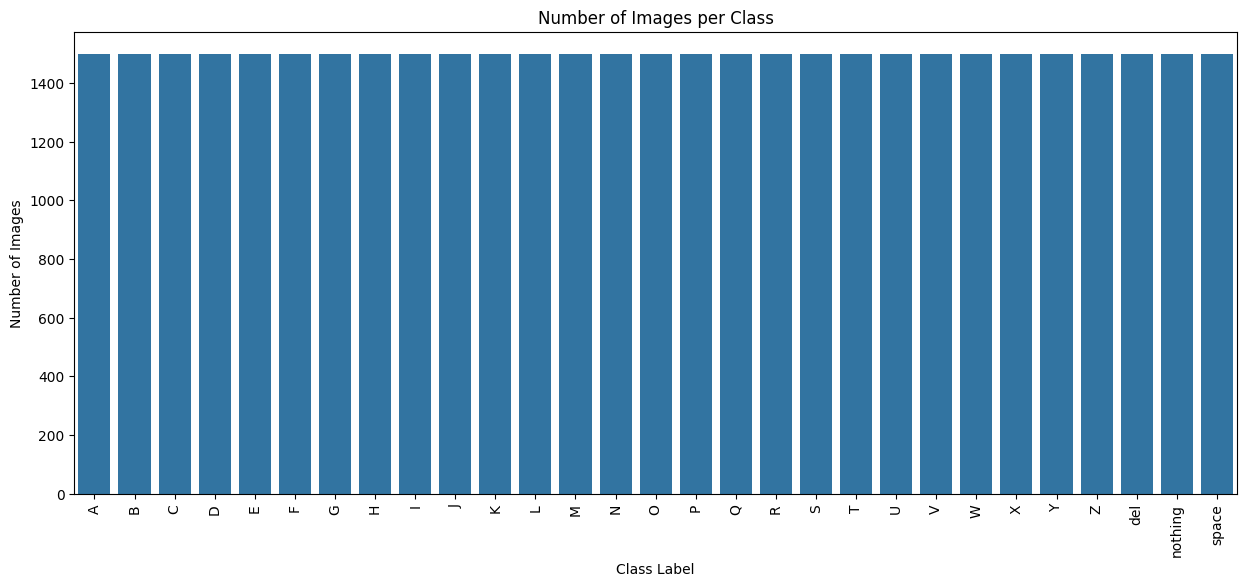

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of images per class
class_counts = metadata['label'].value_counts()

# Create a bar plot
plt.figure(figsize=(15, 6))
sns.countplot(x='label', data=metadata, order=class_counts.index)
plt.xticks(rotation=90)
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()

## **Tiền xử lý dữ liệu**

In [32]:
import os
from glob import glob
import pandas as pd

CLASSES = sorted(os.listdir(TRAINING_DIR))

list_path = []
list_labels = []


for label in CLASSES:
    label_path = os.path.join(TRAINING_DIR, label, "*")
    image_files = glob(label_path)

    sign_label = [label] * len(image_files)


    list_path.extend(image_files)
    list_labels.extend(sign_label)


metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})


print(metadata.head())
print(f"Tổng số ảnh: {len(metadata)}")


                                        image_path label
0   /content/dataset/asl_alphabet_train/A/A631.jpg     A
1  /content/dataset/asl_alphabet_train/A/A1389.jpg     A
2   /content/dataset/asl_alphabet_train/A/A242.jpg     A
3   /content/dataset/asl_alphabet_train/A/A224.jpg     A
4   /content/dataset/asl_alphabet_train/A/A940.jpg     A
Tổng số ảnh: 43500


In [33]:
# Tách thành 3 tập train, validation, test theo tỉ lệ như config

X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"],
    test_size=TEST_SIZE,
    random_state=2023,
    shuffle=True,
    stratify=metadata["label"]
)

data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=VALIDATION_SIZE/TRAIN_SIZE,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

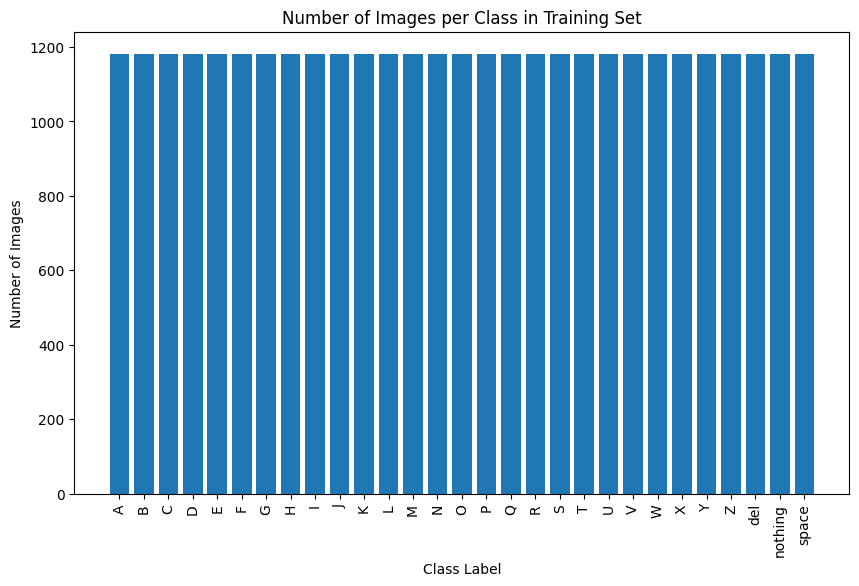

In [71]:
train_counts = data_train['label'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(train_counts.index, train_counts.values)
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Set')
plt.xticks(rotation=90)
plt.show()

In [34]:
datagen = ImageDataGenerator(rescale=1/255.,)

train_gen = ImageDataGenerator(
    rescale=1/255.,
    brightness_range=[0.8,1.2],
    zoom_range=[1.0,1.2],
    horizontal_flip=True)

train_generator = train_gen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
    )

validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
    )

test_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        shuffle=False
)

Found 34256 validated image filenames belonging to 29 classes.
Found 4894 validated image filenames belonging to 29 classes.
Found 4894 validated image filenames belonging to 29 classes.


# **3. Xây dựng mô hình**

## **Transfer learning using Inception V3 Network**

In [39]:
base_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top = False,
    weights = 'imagenet'
)

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## **Huấn luyện mô hình**

**Looking at the final model:**

In [40]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 200, 200, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 99, 99, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 99, 99, 32)     │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 99, 99, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 97, 97, 32)     │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 97, 97, 32)     │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 97, 97, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 97, 97, 64)     │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 97, 97, 64)     │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 97, 97, 64)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 48, 48, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 48, 48, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 48, 48, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 48, 48, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 23,930,685 (91.29 MB)

 Trainable params: 2,127,901 (8.12 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

**Setting up a callback funtion in order to stop training at a particular threshold:**

**Fit model :**

In [41]:
train_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    # callbacks=[callback]
)

Epoch 1/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 434s 780ms/step - accuracy: 0.7640 - loss: 0.9571 - val_accuracy: 0.8735 - val_loss: 0.4014
Epoch 2/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 412s 760ms/step - accuracy: 0.9511 - loss: 0.1525 - val_accuracy: 0.9273 - val_loss: 0.2241
Epoch 3/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 404s 746ms/step - accuracy: 0.9630 - loss: 0.1114 - val_accuracy: 0.9383 - val_loss: 0.1857
Epoch 4/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 408s 754ms/step - accuracy: 0.9766 - loss: 0.0742 - val_accuracy: 0.9581 - val_loss: 0.1305
Epoch 5/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 404s 747ms/step - accuracy: 0.9701 - loss: 0.0891 - val_accuracy: 0.9268 - val_loss: 0.2493


## **Fine-Tuning**

In [42]:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 200, 200, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 99, 99, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 99, 99, 32)     │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 99, 99, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 97, 97, 32)     │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 97, 97, 32)     │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 97, 97, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 97, 97, 64)     │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 97, 97, 64)     │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 97, 97, 64)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 48, 48, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 48, 48, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 48, 48, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 48, 48, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 23,930,685 (91.29 MB)

 Trainable params: 13,242,781 (50.52 MB)

 Non-trainable params: 10,687,904 (40.77 MB)

In [44]:
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    # callbacks=[callback]
)

Epoch 1/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 440s 773ms/step - accuracy: 0.8324 - loss: 0.5951 - val_accuracy: 0.9383 - val_loss: 0.2202
Epoch 2/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 402s 742ms/step - accuracy: 0.9732 - loss: 0.1115 - val_accuracy: 0.9624 - val_loss: 0.1435
Epoch 3/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 403s 741ms/step - accuracy: 0.9840 - loss: 0.0699 - val_accuracy: 0.9722 - val_loss: 0.1086
Epoch 4/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 404s 746ms/step - accuracy: 0.9890 - loss: 0.0506 - val_accuracy: 0.9759 - val_loss: 0.0904
Epoch 5/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 402s 743ms/step - accuracy: 0.9914 - loss: 0.0399 - val_accuracy: 0.9794 - val_loss: 0.0754


## **Lưu mô hình**

**As we were satisfied with our results we save our model:**

In [48]:
# Saving the model
model.save(MODEL_PATH)

# **4. Đánh giá mô hình**

## **Model Testing**

In [49]:
predictions = model.predict(test_generator)
predictions = predictions.argmax(axis=1)
true_labels = test_generator.classes

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(predictions, true_labels)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", accuracy))

4894/4894 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step
Evaluate Test Accuracy: 0.98%


## **Training Loss and Metrics**

In [50]:
def visualize_train_val(history):
  # Visualize Training and Validation Results
  fig = make_subplots(
          rows=1, cols=2,
          subplot_titles=["Model Loss", "Model Accuracy"],
  )

  # Configuration Plot
  class PlotCFG:
      marker_size = 8
      line_size = 2
      train_color = "#76503d"
      valid_color = "#deb392"


  # Loss Plot
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(loss)+1), y=loss,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.train_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
          name="Training Loss"
      ), row=1, col=1
  )

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(val_loss)+1), y=val_loss,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.valid_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
          name="Validation Loss"
      ), row=1, col=1
  )



  # Accuracy Plot
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(acc)+1), y=acc,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.train_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
          name="Training Accuracy"
      ), row=1, col=2
  )
  fig.add_trace(
      go.Scatter(
          x=np.arange(1, len(val_acc)+1), y=val_acc,
          mode="markers+lines",
          marker=dict(
              color=PlotCFG.valid_color, size=PlotCFG.marker_size,
              line=dict(color="White", width=0.5)
          ),
          line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
          name="Validation Accuracy"
      ), row=1, col=2
  )

  # Update Axes
  fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
  fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
  fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)
  fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)


  # Update Layout
  fig.update_layout(
      title="Training Loss and Metrics", title_x=0.5,
      width=950, height=400,
      showlegend=False,
      plot_bgcolor="White",
      paper_bgcolor="White"
  )

  # Show
  fig.show(iframe_connected=True)


In [51]:
visualize_train_val(train_history)

### Fine-tune

In [52]:
visualize_train_val(fine_tune_history)

## **Confusion Matrix**

In [53]:
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions,
        num_classes=29)

In [54]:
# Create Figure
fig = go.Figure()

# Heatmap
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix,
        x=CLASSES,
        y=CLASSES,
        text=confusion_matrix,
        texttemplate="<b>%{text}</b>",
        textfont={"size":8},
        colorscale=[[0, '#f4f4f4'],[1.0, '#76503d']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14,
                  width=1050,
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()

## **Kiểm tra ảnh trên thực tế**

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
D


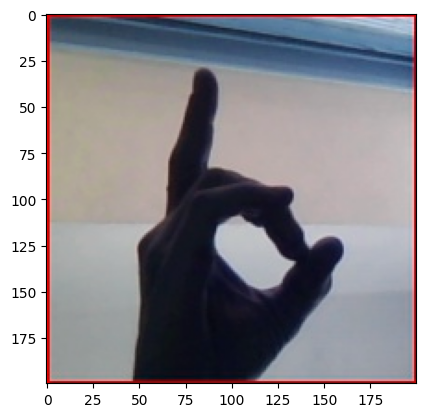

In [55]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_location = '/content/dataset/asl_alphabet_test/D_test.jpg'

# Creating list of available classes stored in classes.txt.
classes_file = open("classes.txt")
classes_string = classes_file.readline()
classes = classes_string.split()
classes.sort()  # The predict function sends out output in sorted order.

IMAGE_SIZE = 200

# Check if the image file exists
import os
if not os.path.exists(image_location):
    raise FileNotFoundError(f"Image file not found at: {image_location}")

img = cv2.imread(image_location)

# Check if the image was loaded successfully
if img is None:
    raise IOError(f"Failed to load image from: {image_location}")

img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
img = np.array(img) / 255.
plt.imshow(img)
img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))

prediction = np.array(model.predict(img))
predicted = classes[prediction.argmax()]

print(predicted)